In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import torch, os, random
import torch.nn as nn
import timm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class Classifier(nn.Module):
    def __init__(self, model, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [ ]:
model_name = 'inception_resnet_v2' # inception_v4 inception_resnet_v2
hidden_size = 768
pretrained = False
model = timm.create_model(model_name, pretrained=pretrained, num_classes=hidden_size)

In [ ]:
classifier = Classifier(model, num_classes=6).to(device)

In [ ]:
dict_file = '/content/drive/MyDrive/CV_project/skin_model/inception_resnet_v2.pt'

In [ ]:
pretrained = torch.load(dict_file)

state_dict = pretrained['state_dict']
labels = pretrained['label']

model_dict = model.state_dict()
model_dict.update(state_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
labels

['무증상', '유증상']

# to .onnx

In [ ]:
import torch.onnx

In [ ]:
classifier.eval()

In [ ]:
model_path = '/content/drive/MyDrive/CV_project/skin_model'

In [ ]:
torch_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(classifier, torch_input, os.path.join(model_path, 'binary_inception_v4.onnx'))

# onnx inference

In [6]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.0 MB/s eta 0:00:00


In [7]:
import onnxruntime
from scipy.special import softmax
from PIL import Image
from torchvision.transforms import ToTensor

In [9]:
dict_file = '/content/drive/MyDrive/CV_project/skin_model/inception_resnet_v2.pt'
pretrained = torch.load(dict_file)
labels = pretrained['label']
labels

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴']

In [10]:
model_path = '/content/drive/MyDrive/CV_project/skin_model'

In [11]:
filepath = os.path.join(model_path, 'inception_resnet_v2.onnx')
ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name

In [12]:
def inference(img_path, labels):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0)

    ort_inputs = {input_name: img.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)

    result = softmax(ort_outs)
    result_dict = {}

    for i, value in enumerate(result[0][0].tolist()):
        result_dict[labels[i]] = value

    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return result

In [42]:
def inference_simple(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0)

    ort_inputs = {input_name: img.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)

    result = softmax(ort_outs)
    return (result[0][0].argmax(), result[0][0].tolist())

In [43]:
root = '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized'

In [45]:
predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    if folder.startswith('A'):
        for file in os.listdir(os.path.join(root, folder)):
            predictions['target'].append(int(folder[1])-1)
            inf_result = inference_simple(os.path.join(root, folder, file))
            predictions['pred'].append(inf_result[0])
            predictions['probs'].append(inf_result[1])

            if len(predictions['pred']) % 1000 == 0:
                print(len(predictions['pred']), "done")

A1_구진_플라크 4068
1000 done
2000 done
3000 done
4000 done
무증상 17401
A2_비듬_각질_상피성잔고리 7849
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
11000 done
A3_태선화_과다색소침착 6746
12000 done
13000 done
14000 done
15000 done
16000 done
17000 done
18000 done
A4_농포_여드름 1668
19000 done
20000 done
A5_미란_궤양 1500
21000 done
A6_결절_종괴 1514
22000 done
23000 done


In [46]:
from collections import Counter

Counter(predictions['target'])

Counter({0: 4068, 1: 7849, 2: 6746, 3: 1668, 4: 1500, 5: 1514})

In [47]:
for folder in os.listdir(root):
    if folder.startswith('A'):
        print(folder, len(os.listdir(os.path.join(root, folder))))

A1_구진_플라크 4068
A2_비듬_각질_상피성잔고리 7849
A3_태선화_과다색소침착 6746
A4_농포_여드름 1668
A5_미란_궤양 1500
A6_결절_종괴 1514


In [48]:
preds = list(map(int, predictions['pred']))
predictions['pred'] = preds

In [78]:
import json
with open('/content/drive/MyDrive/CV_project/skin_model/prediction/multi-irv2-epoch30.json', 'w') as f:
    json.dump(predictions, f)

In [50]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

[Text(0, 0.5, 'A1_구진_플라크'),
 Text(0, 1.5, 'A2_비듬_각질_상피성잔고리'),
 Text(0, 2.5, 'A3_태선화_과다색소침착'),
 Text(0, 3.5, 'A4_농포_여드름'),
 Text(0, 4.5, 'A5_미란_궤양'),
 Text(0, 5.5, 'A6_결절_종괴')]

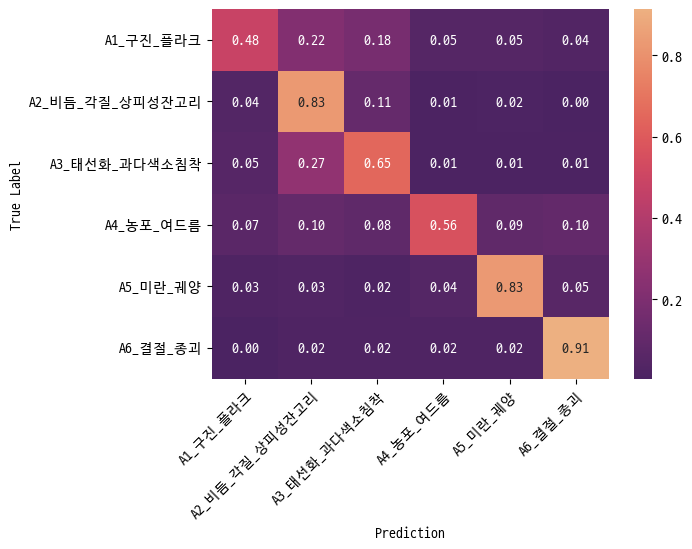

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# labels = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=labels, fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
hm.set_yticklabels(labels=labels, fontsize=10, rotation=0)

In [52]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)

              precision    recall  f1-score   support

           0       0.72      0.48      0.58      4068
           1       0.69      0.83      0.75      7849
           2       0.71      0.65      0.68      6746
           3       0.69      0.56      0.62      1668
           4       0.69      0.83      0.75      1500
           5       0.74      0.91      0.82      1514

    accuracy                           0.70     23345
   macro avg       0.71      0.71      0.70     23345
weighted avg       0.70      0.70      0.69     23345



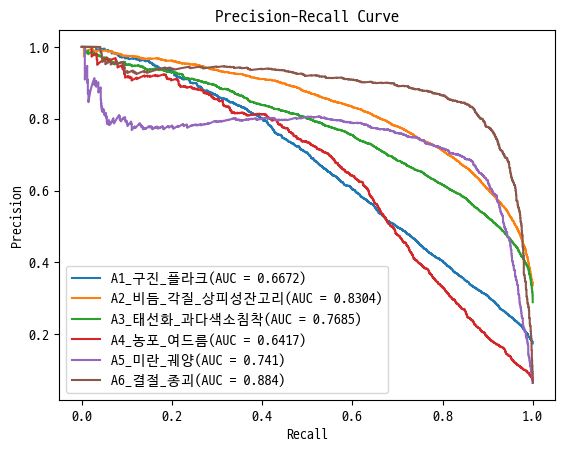

In [76]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np

legend = []

for i in range(len(labels)):
    target = np.array(predictions['target'])==i
    target = target.astype(int)
    probs = np.array(predictions['probs'])[:, i]

    precision, recall, thresholds = precision_recall_curve(target, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision)
    legend.append(labels[i] + '(AUC = ' + str(round(pr_auc,4)) + ')')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(legend, loc='lower left')
plt.show()